Бернухова Анастасия

# Загрузка данных и библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mpl_dates
import plotly.graph_objects as go
from datetime import datetime

import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon

from sklearn.metrics import mean_squared_error, mean_absolute_error

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


In [2]:
df = pd.read_csv('EURUSD_210201_210430.csv')

In [3]:
df.head()

<DATE>    <TIME>   <OPEN>   <HIGH>   <LOW>  <CLOSE>    <VOL>
0  20210201  00:00:00  1.21227  1.21365  1.2053  1.20677  2019703
1  20210202  00:00:00  1.20677  1.20878  1.2010  1.20360  1862755
2  20210203  00:00:00  1.20368  1.20502  1.2002  1.20410  1406126
3  20210204  00:00:00  1.20413  1.20430  1.1956  1.19656  1455889
4  20210205  00:00:00  1.19663  1.20500  1.1951  1.20476  1252436

# Предобработка данных

In [4]:
df.columns = [colname[1:-1] for colname in df.columns] #чтобы названия колонок без кавычек были

In [5]:
df.head()

DATE      TIME     OPEN     HIGH     LOW    CLOSE      VOL
0  20210201  00:00:00  1.21227  1.21365  1.2053  1.20677  2019703
1  20210202  00:00:00  1.20677  1.20878  1.2010  1.20360  1862755
2  20210203  00:00:00  1.20368  1.20502  1.2002  1.20410  1406126
3  20210204  00:00:00  1.20413  1.20430  1.1956  1.19656  1455889
4  20210205  00:00:00  1.19663  1.20500  1.1951  1.20476  1252436

In [6]:
df['DATE'] = df['DATE'].apply(lambda x: str(x)[:4] + '-' + str(x)[4:6] + '-' + str(x)[6:]) 
#переводим даты в формат понятный питону

df.head()

DATE      TIME     OPEN     HIGH     LOW    CLOSE      VOL
0  2021-02-01  00:00:00  1.21227  1.21365  1.2053  1.20677  2019703
1  2021-02-02  00:00:00  1.20677  1.20878  1.2010  1.20360  1862755
2  2021-02-03  00:00:00  1.20368  1.20502  1.2002  1.20410  1406126
3  2021-02-04  00:00:00  1.20413  1.20430  1.1956  1.19656  1455889
4  2021-02-05  00:00:00  1.19663  1.20500  1.1951  1.20476  1252436

# Немного визуализации

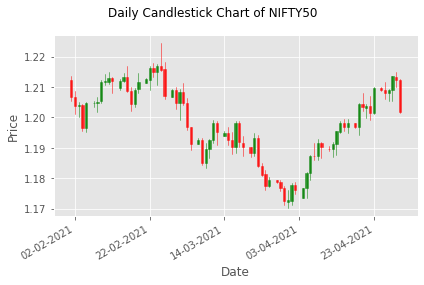

In [7]:
# тут свечи ч/з матплотлиб... некрасивые вышли

plt.style.use('ggplot')

ohlc = df.loc[:, ['DATE', 'OPEN', 'HIGH', 'LOW', 'CLOSE']]
ohlc['DATE'] = pd.to_datetime(ohlc['DATE'])
ohlc['DATE'] = ohlc['DATE'].apply(mpl_dates.date2num)
ohlc = ohlc.astype(float)

fig, ax = plt.subplots()

candlestick_ohlc(ax, ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)

# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
fig.suptitle('Daily Candlestick Chart of NIFTY50')

# Formatting Date
date_format = mpl_dates.DateFormatter('%d-%m-%Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

fig.tight_layout()

plt.show()



In [8]:
# график свечей, более красивый
fig = go.Figure(data=[go.Candlestick(x=df['DATE'],
                open=df['OPEN'],
                high=df['HIGH'],
                low=df['LOW'],
                close=df['CLOSE'])])

fig.show()

# SSA

In [9]:
# будем делать по цене открытия
open_date = df[['DATE', 'OPEN']]
    
# немного предобработки
open_date['DATE'] = pd.to_datetime(open_date['DATE'])
open_date = open_date.set_index('DATE') # чтобы было в виде одномерного массива и индексировалось по дате
open_date = open_date.asfreq('D') # добавит те даты, которые пропущены в таблице
open_date = open_date.dropna() # убираем наны, иначе не работает SVD


<ipython-input-9-084014c35050>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [10]:
# https://www.kaggle.com/jdarcy/introducing-ssa-for-time-series-decomposition

class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        
        """
        Разлагает данный временной ряд с помощью SSA. Предполагает, что значения временного ряда
        записываются с равными интервалами.
        
        Параметры
        ----------
        tseries: исходный временной ряд типа Pandas Series, NumPy array or list.
        L: длина окна. Должно быть целым числом 2 <= L <= N / 2, где N - длина временного ряда.
        save_mem: экономия памяти за счет отказа от элементарных матриц. Рекомендуется для длинных временных рядов с
            тысячами значений. По умолчанию True.
        
        Примечание. Даже если массив или NumPy array используется для начального временного ряда, все возвращенные временные ряды будут
        в виде объекта Pandas Series или DataFrame.
        """
        
        # Проверка типов для начального временного ряда
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Проверка 2 <= L <= N / 2
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        
        
        # 1 шаг (вложение): Создание траекторной матрицы из временного ряда
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # 2 шаг (сингулярное разложение): Разложение траекторной матрицы
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        # если плохо по памяти - отказываемся от элементарных матриц:
        if not save_mem:
            # если ок по памяти, то
            
            # строим и сохраняем все элементарные матрицы
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # 4 шаг (диаг усредн): усредняем элементарные матрицы по диагонали, сохраняем их как столбцы в массиве.
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # восстанавливаем элементарные матрицы, не сохраняя их (если не ок с памятью)
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # массив V также может быть очень большим, поэтому мы не будем его оставлять
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Рассчет w-корреляционной матрицы.
        self.calc_wcorr()
        
    def components(self, n=0):
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        return self.TS_comps[:, :n]
            
    def components_to_df(self, n=0):
        """
        Возвращает все компоненты временных рядов в одном объекте Pandas DataFrame.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Создает список столбцов с названиями F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
    
    def reconstruct(self, indices):
        """
        Восстанавливает временной ряд по его элементарным компонентам, используя заданные индексы. Возвращает объект типа 
        Pandas Series с реконструированным временным рядом.
        
        Параметры
        ----------
        indices: целое число, список целых чисел или объект среза (n, m), представляющий элементарные 
        компоненты для суммирования.
        """
        
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Вычисляет матрицу w-корреляции для временного ряда.
        """
             
        # Вычисляет веса
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
        return self.Wcorr
    
    def plot_wcorr(self, min=None, max=None):
        """
        Строит w-корреляционную матрицу для разложенного временного ряда.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)
        

# Разложение на 3, 38 и 26 компонент

### Разложение на 3 компоненты

In [11]:
open_price = open_date['OPEN'].to_numpy()
F = open_price

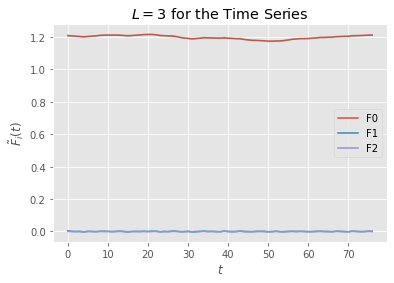

In [12]:
F_ssa_L3 = SSA(F, 3)

F_ssa_L3.components_to_df().plot()
F_ssa_L3.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=3$ for the Time Series");
plt.show()

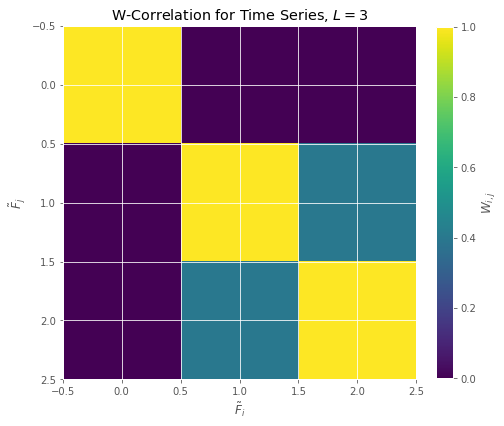

In [13]:
plt.figure(figsize=(7, 7)) #для большего размера графика
F_ssa_L3.plot_wcorr()
plt.title("W-Correlation for Time Series, $L=3$");

In [14]:
# матрица корреляции
F_ssa_L3.calc_wcorr()

array([[1.00000000e+00, 1.67919192e-03, 1.45972259e-04],
       [1.67919192e-03, 1.00000000e+00, 4.00265752e-01],
       [1.45972259e-04, 4.00265752e-01, 1.00000000e+00]])

### Разложение на 38 компонент (~N/2)

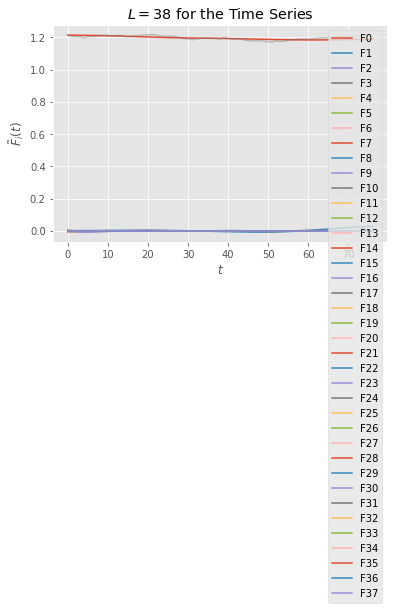

In [15]:
F_ssa_L38 = SSA(F, 38)
F_ssa_L38.components_to_df().plot()
F_ssa_L38.orig_TS.plot(alpha=0.4)

plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=38$ for the Time Series");
plt.show()

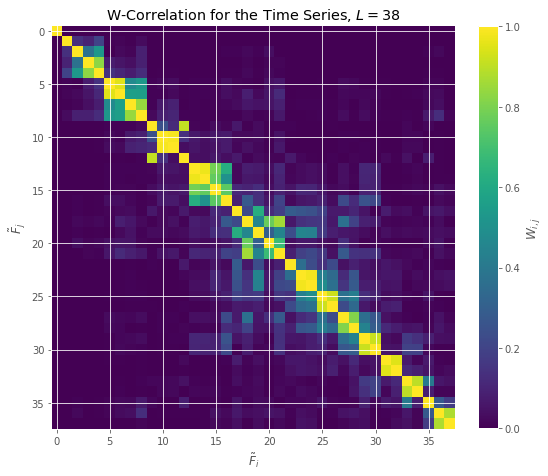

In [16]:
plt.figure(figsize=(8, 8))
F_ssa_L38.plot_wcorr()
plt.title("W-Correlation for the Time Series, $L=38$");

In [17]:
# матрица корреляции
F_ssa_L38.calc_wcorr()

array([[1.00000000e+00, 1.15479869e-03, 1.59753933e-04, ...,
        6.51972136e-06, 8.56738937e-06, 7.79631295e-07],
       [1.15479869e-03, 1.00000000e+00, 1.39597206e-01, ...,
        1.00412425e-05, 4.73367356e-05, 1.47329524e-05],
       [1.59753933e-04, 1.39597206e-01, 1.00000000e+00, ...,
        1.15775215e-02, 2.21747459e-02, 1.38085546e-03],
       ...,
       [6.51972136e-06, 1.00412425e-05, 1.15775215e-02, ...,
        1.00000000e+00, 2.80525943e-01, 1.78780464e-01],
       [8.56738937e-06, 4.73367356e-05, 2.21747459e-02, ...,
        2.80525943e-01, 1.00000000e+00, 8.75354664e-01],
       [7.79631295e-07, 1.47329524e-05, 1.38085546e-03, ...,
        1.78780464e-01, 8.75354664e-01, 1.00000000e+00]])

### Разложение на 26 компонент (~N/3)

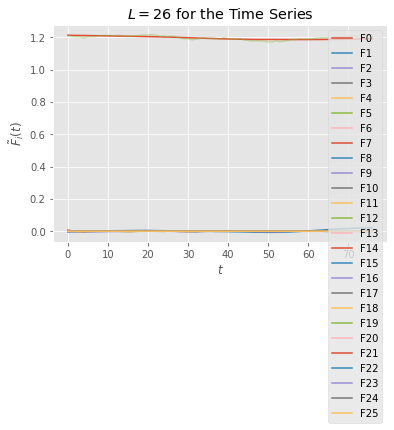

In [18]:
F_ssa_L26 = SSA(F, 26)
F_ssa_L26.components_to_df().plot()
F_ssa_L26.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=26$ for the Time Series");
plt.show()

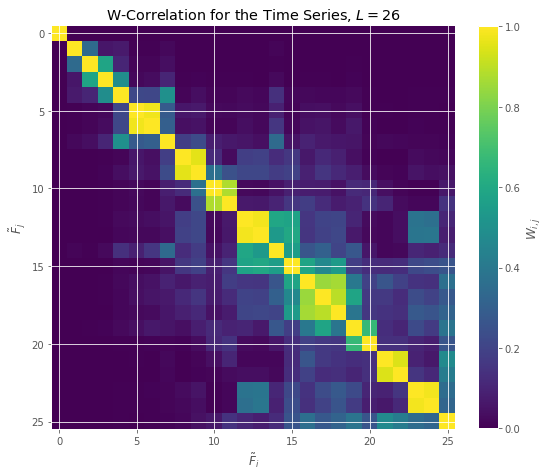

In [19]:
plt.figure(figsize=(8, 8))
F_ssa_L26.plot_wcorr()
plt.title("W-Correlation for the Time Series, $L=26$");

## Визуальная группировка (отделение от шума)

с 12 по 25 наблюдается корреляция

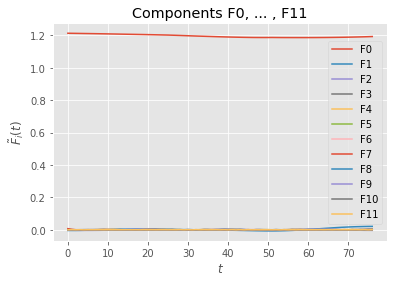

In [20]:
F_ssa_L26.components_to_df().loc[:,'F0':'F11'].plot()

plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Components F0, ... , F11");

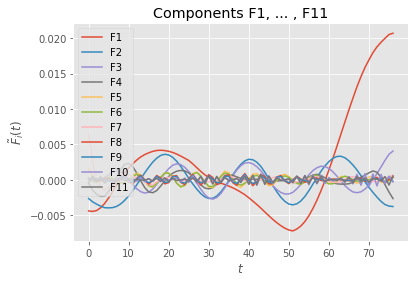

In [21]:
#посмотрим отдельно на компоненты, которые ходим сгруппировать
F_ssa_L26.components_to_df().loc[:,'F1':'F11'].plot()

plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Components F1, ... , F11");

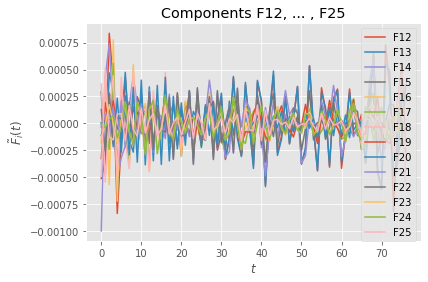

In [22]:
F_ssa_L26.components_to_df().loc[:,'F12':'F25'].plot()

plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Components F12, ... , F25");

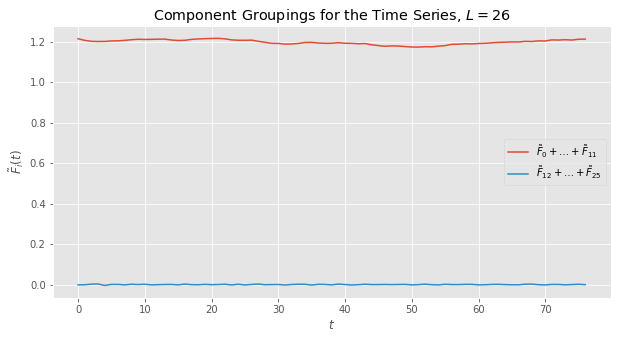

In [23]:
# группировка
plt.figure(figsize=(10, 5))
F_ssa_L26.reconstruct(slice(0,11)).plot()
F_ssa_L26.reconstruct(slice(12,25)).plot()

plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for the Time Series, $L=26$");
plt.legend([r"$\tilde{F}_0 + \ldots + \tilde{F}_{11}$", 
            r"$\tilde{F}_{12} + \ldots + \tilde{F}_{25}$"]);

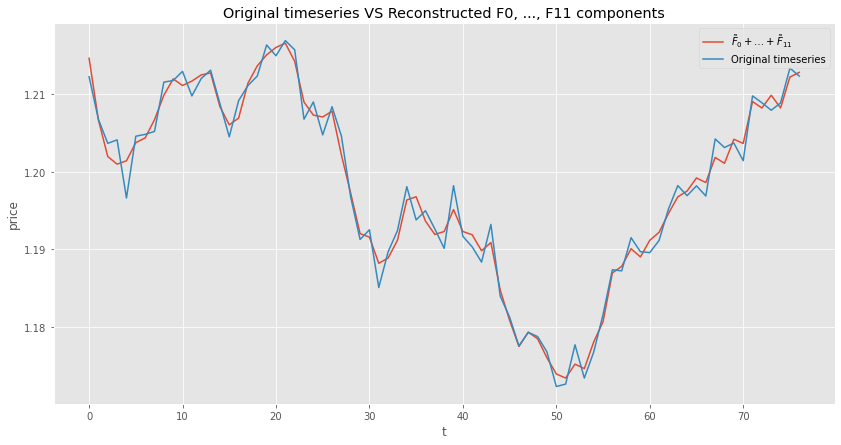

In [24]:
plt.figure(figsize=(14, 7))
F_ssa_L26.reconstruct(slice(0,11)).plot()
pd.Series(open_price).plot()

plt.xlabel('t')
plt.ylabel('price')
plt.title('Original timeseries VS Reconstructed F0, ..., F11 components');
plt.legend([r"$\tilde{F}_0 + \ldots + \tilde{F}_{11}$", 
            'Original timeseries']);

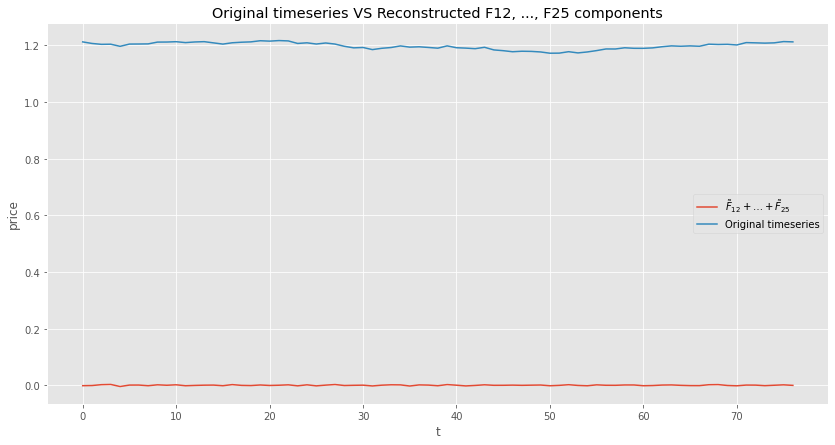

In [25]:
plt.figure(figsize=(14, 7))
F_ssa_L26.reconstruct(slice(12,25)).plot()
pd.Series(open_price).plot()

plt.xlabel('t')
plt.ylabel('price')
plt.title('Original timeseries VS Reconstructed F12, ..., F25 components');
plt.legend([r"$\tilde{F}_{12} + \ldots + \tilde{F}_{25}$", 
            'Original timeseries']);

In [26]:
comp1 = F_ssa_L26.reconstruct(slice(0,11))
comp2 = F_ssa_L26.reconstruct(slice(12,25))

## Тестирование компонент на нормальность

Тест Колмогорова-Смирнова для нормального распределения с оценкой местоположения и масштаба также называется тест Lilliefors.

Lilliefors’ test is a Kolmogorov-Smirnov test with estimated parameters.

In [27]:
sm.stats.lilliefors(comp1.to_numpy())

(0.11001018710189181, 0.03504413483998005)

In [28]:
sm.stats.lilliefors(comp2.to_numpy())

(0.052484345690771705, 0.9054215933268338)

Для первой компоненты p-value < 0.05, гипотеза о нормальном распределении отвергается.

Для второй компоненты p-value > 0.05, гипотеза о норм распред не отвергаетстя.

## Посмотрим на собственные значения 

In [29]:
#open_price = open_date['OPEN'].to_numpy() #цены открытия
#open_price

In [30]:
#N = len(open_price)
#N

In [31]:
#L = 26 #число компонент
#X = np.array([pd.Series(F).values[i:L+i] for i in range(0, N-L+1)]).T
#U, Sigma, VT = np.linalg.svd(X)
#d = np.linalg.matrix_rank(X)
#d

In [32]:
#график собственных значений
#plt.figure(figsize=(15, 10))
#plt.plot(np.log(Sigma), marker=".")

In [33]:
# он же, но ближе, ниже -2
#plt.figure(figsize=(12, 8))
#plt.plot(np.log(Sigma), marker=".")
#plt.ylim(top=-2)

# Группировка по взвешенной корреляции

In [34]:
# F_ssa_L26 = SSA(F, 26)
corr_matr = pd.DataFrame(F_ssa_L26.calc_wcorr()) #матрица корреляций в виде дф
corr_matr.head()

0         1         2         3         4         5         6   \
0  1.000000  0.002236  0.000214  0.000025  0.000122  0.000010  0.000012   
1  0.002236  1.000000  0.345320  0.061529  0.073280  0.005232  0.005790   
2  0.000214  0.345320  1.000000  0.583987  0.104002  0.015402  0.012382   
3  0.000025  0.061529  0.583987  1.000000  0.491638  0.022505  0.031717   
4  0.000122  0.073280  0.104002  0.491638  1.000000  0.218536  0.212200   

         7         8         9   ...        16        17        18        19  \
0  0.000002  0.000002  0.000001  ...  0.000003  0.000005  0.000002  0.000007   
1  0.021984  0.001257  0.002629  ...  0.002288  0.000942  0.000289  0.001584   
2  0.035808  0.001234  0.003417  ...  0.002624  0.003359  0.002213  0.004991   
3  0.101612  0.005267  0.011029  ...  0.005720  0.006362  0.003708  0.008292   
4  0.503291  0.012091  0.035832  ...  0.019843  0.018828  0.015672  0.024361   

         20            21            22        23        24        25  
0  0.000001  3.187796e-07  2.678516e-07  0.000004  0.000003  0.000001  
1  0.000140  1.088117e-05  2.206288e-06  0.000166  0.000242  0.000920  
2  0.001385  4.798075e-04  4.627808e-04  0.001476  0.001076  0.000986  
3  0.001816  9.536818e-04  8.409160e-04  0.002201  0.001248  0.002804  
4  0.006074  2.433166e-03  2.409740e-03  0.006305  0.004123  0.005955  

[5 rows x 26 columns]

In [35]:
# проверка пропусков и отрицательных значений
corr_matr.isnull().values.any() & np.isnan(corr_matr).values.any() & corr_matr[corr_matr >= 0].isnull().values.any()

False

In [36]:
# создает дф из попарных корреляций по убыванию
df_corr = corr_matr.abs().unstack().sort_values(kind="quicksort", ascending=False)
df_corr = df_corr[df_corr < 1].drop_duplicates()
df_corr


13  12    9.833058e-01
24  23    9.808481e-01
6   5     9.768907e-01
8   9     9.596438e-01
22  21    9.485301e-01
              ...     
0   13    7.673626e-07
15  0     6.653075e-07
0   12    5.694310e-07
21  0     3.187796e-07
22  0     2.678516e-07
Length: 325, dtype: float64

## Пример группировки компонент 

(чтобы потом понять как дальше это делать со всеми)

Объединим 5 и 6, 12 и 13, 23 и 24 (так как имеют наибольшие значения корреляции)

In [37]:
df_components = F_ssa_L26.components_to_df() #исходные компоненты в виде дф
components = F_ssa_L26.components() #исходные компоненты, но в виде array, а не дф
df_components

F0        F1        F2        F3        F4        F5        F6  \
0   1.213555 -0.004412 -0.002657  0.000269 -0.000509  0.001574  0.000166   
1   1.213146 -0.004474 -0.003121 -0.000158 -0.001474  0.000342 -0.000198   
2   1.212767 -0.004350 -0.003454 -0.000277 -0.002052 -0.000245 -0.000352   
3   1.212381 -0.003960 -0.003728 -0.000081 -0.002349 -0.000220 -0.000172   
4   1.211964 -0.003357 -0.003954  0.000273 -0.002330 -0.000002  0.000163   
..       ...       ...       ...       ...       ...       ...       ...   
72  1.190391  0.018775 -0.002453  0.000873  0.001057  0.000156  0.000191   
73  1.190959  0.019419 -0.003056  0.001796  0.000344 -0.000314 -0.000049   
74  1.191600  0.019985 -0.003508  0.002738 -0.000703 -0.000483 -0.000216   
75  1.192373  0.020520 -0.003724  0.003591 -0.001739 -0.000096 -0.000056   
76  1.193170  0.020703 -0.003787  0.004054 -0.002665  0.000578  0.000302   

              F7        F8        F9  ...       F16           F17  \
0   6.549944e-03  0.000034  0.000083  ... -0.000180  4.324033e-08   
1   2.439091e-03  0.000063  0.000097  ...  0.000401 -6.355274e-06   
2   6.989535e-07 -0.000180  0.000114  ... -0.000569 -2.417303e-04   
3  -1.077540e-03 -0.000054  0.000067  ...  0.000775  5.578305e-04   
4  -1.497449e-03  0.000273  0.000033  ... -0.000720 -4.172587e-04   
..           ...       ...       ...  ...       ...           ...   
72 -2.687903e-04  0.000335  0.000055  ... -0.000021  6.535354e-06   
73 -4.572605e-05 -0.000082  0.000157  ... -0.000036  7.039354e-05   
74  2.539589e-04 -0.000386 -0.000500  ... -0.000080  3.417146e-05   
75  3.683647e-04  0.000031  0.000478  ...  0.000119  3.454619e-05   
76  6.303068e-04  0.000381 -0.000232  ...  0.000122 -4.336107e-05   

             F18       F19       F20       F21       F22       F23  \
0   3.664631e-04 -0.000326 -0.000113 -0.000035  0.000129 -0.000125   
1  -5.441546e-04  0.000193  0.000020  0.000086 -0.000255 -0.000013   
2   1.151799e-04 -0.000061  0.000164 -0.000131  0.000282  0.000174   
3   4.435491e-04  0.000208 -0.000217  0.000158 -0.000185  0.000001   
4  -5.133963e-04 -0.000042  0.000235 -0.000182  0.000059 -0.000186   
..           ...       ...       ...       ...       ...       ...   
72  7.676143e-05 -0.000187 -0.000056 -0.000011  0.000045 -0.000123   
73  1.706019e-05 -0.000103 -0.000107 -0.000004 -0.000053 -0.000094   
74 -3.882738e-05  0.000212  0.000128  0.000002  0.000047  0.000197   
75  9.948708e-06  0.000506  0.000018  0.000024  0.000003  0.000085   
76  6.685199e-07 -0.000576 -0.000013 -0.000027 -0.000037 -0.000218   

             F24       F25  
0  -9.947251e-07 -0.000492  
1  -3.817250e-05  0.000512  
2   3.906968e-05 -0.000125  
3   7.173644e-05 -0.000154  
4  -1.358234e-04  0.000086  
..           ...       ...  
72 -1.506497e-04  0.000122  
73  6.323565e-05 -0.000300  
74  1.006028e-04  0.000162  
75 -6.351842e-05  0.000459  
76 -1.212863e-05 -0.000602  

[77 rows x 26 columns]

In [38]:
compon1 = F_ssa_L26.reconstruct([5, 6])
compon2 = F_ssa_L26.reconstruct([12, 13])
compon3 = F_ssa_L26.reconstruct([23, 24])

In [39]:
#заменяем сгруппированные компоненты
df_components_new = df_components.copy()

df_components_new.drop(['F5', 'F6'], axis=1, inplace=True)
df_components_new.insert(5, 'F5 + F6', compon1)

df_components_new.drop(['F12', 'F13'], axis=1, inplace=True)
df_components_new.insert(11, 'F12 + F13', compon2)

df_components_new.drop(['F23', 'F24'], axis=1, inplace=True)
df_components_new.insert(21, 'F23 + F24', compon3)

In [40]:
df_components_new #дф после группировки компонент

F0        F1        F2        F3        F4   F5 + F6            F7  \
0   1.213555 -0.004412 -0.002657  0.000269 -0.000509  0.001740  6.549944e-03   
1   1.213146 -0.004474 -0.003121 -0.000158 -0.001474  0.000143  2.439091e-03   
2   1.212767 -0.004350 -0.003454 -0.000277 -0.002052 -0.000597  6.989535e-07   
3   1.212381 -0.003960 -0.003728 -0.000081 -0.002349 -0.000392 -1.077540e-03   
4   1.211964 -0.003357 -0.003954  0.000273 -0.002330  0.000161 -1.497449e-03   
..       ...       ...       ...       ...       ...       ...           ...   
72  1.190391  0.018775 -0.002453  0.000873  0.001057  0.000347 -2.687903e-04   
73  1.190959  0.019419 -0.003056  0.001796  0.000344 -0.000364 -4.572605e-05   
74  1.191600  0.019985 -0.003508  0.002738 -0.000703 -0.000699  2.539589e-04   
75  1.192373  0.020520 -0.003724  0.003591 -0.001739 -0.000151  3.683647e-04   
76  1.193170  0.020703 -0.003787  0.004054 -0.002665  0.000880  6.303068e-04   

          F8        F9       F10  ...       F15       F16           F17  \
0   0.000034  0.000083  0.000007  ...  0.000295 -0.000180  4.324033e-08   
1   0.000063  0.000097  0.000035  ... -0.000475  0.000401 -6.355274e-06   
2  -0.000180  0.000114  0.000010  ...  0.000262 -0.000569 -2.417303e-04   
3  -0.000054  0.000067  0.000188  ...  0.000264  0.000775  5.578305e-04   
4   0.000273  0.000033 -0.000135  ... -0.000510 -0.000720 -4.172587e-04   
..       ...       ...       ...  ...       ...       ...           ...   
72  0.000335  0.000055 -0.000868  ...  0.000179 -0.000021  6.535354e-06   
73 -0.000082  0.000157  0.000759  ...  0.000173 -0.000036  7.039354e-05   
74 -0.000386 -0.000500 -0.000532  ... -0.000303 -0.000080  3.417146e-05   
75  0.000031  0.000478  0.000484  ... -0.000153  0.000119  3.454619e-05   
76  0.000381 -0.000232 -0.000294  ...  0.000360  0.000122 -4.336107e-05   

             F18       F19       F20       F21       F22  F23 + F24       F25  
0   3.664631e-04 -0.000326 -0.000113 -0.000035  0.000129  -0.000126 -0.000492  
1  -5.441546e-04  0.000193  0.000020  0.000086 -0.000255  -0.000051  0.000512  
2   1.151799e-04 -0.000061  0.000164 -0.000131  0.000282   0.000213 -0.000125  
3   4.435491e-04  0.000208 -0.000217  0.000158 -0.000185   0.000073 -0.000154  
4  -5.133963e-04 -0.000042  0.000235 -0.000182  0.000059  -0.000321  0.000086  
..           ...       ...       ...       ...       ...        ...       ...  
72  7.676143e-05 -0.000187 -0.000056 -0.000011  0.000045  -0.000274  0.000122  
73  1.706019e-05 -0.000103 -0.000107 -0.000004 -0.000053  -0.000031 -0.000300  
74 -3.882738e-05  0.000212  0.000128  0.000002  0.000047   0.000298  0.000162  
75  9.948708e-06  0.000506  0.000018  0.000024  0.000003   0.000022  0.000459  
76  6.685199e-07 -0.000576 -0.000013 -0.000027 -0.000037  -0.000230 -0.000602  

[77 rows x 23 columns]

In [41]:
components_new = np.array(df_components.values.tolist()) #новые компоненты в виде array
components_new

array([[ 1.21355525e+00, -4.41202066e-03, -2.65737001e-03, ...,
        -1.24716586e-04, -9.94725146e-07, -4.92210411e-04],
       [ 1.21314579e+00, -4.47360507e-03, -3.12072734e-03, ...,
        -1.25891176e-05, -3.81724980e-05,  5.12080450e-04],
       [ 1.21276697e+00, -4.34985749e-03, -3.45368077e-03, ...,
         1.73748176e-04,  3.90696791e-05, -1.24833331e-04],
       ...,
       [ 1.19159952e+00,  1.99845061e-02, -3.50764195e-03, ...,
         1.97222795e-04,  1.00602791e-04,  1.62450876e-04],
       [ 1.19237316e+00,  2.05198585e-02, -3.72363382e-03, ...,
         8.53757513e-05, -6.35184238e-05,  4.58734619e-04],
       [ 1.19316979e+00,  2.07027107e-02, -3.78705133e-03, ...,
        -2.17578169e-04, -1.21286264e-05, -6.01816748e-04]])

теперь нужно построить новую матрицу Wcorr

In [42]:
L = 26
N = len(open_price)

d = components.shape[1]
K = N - L + 1

w = np.array(list(np.arange(L)+1) + [L]*(K-L-1) + list(np.arange(L)+1)[::-1])


In [43]:
def calc_wcorr(components, d):

    w = np.array(list(np.arange(L)+1) + [L]*(K-L-1) + list(np.arange(L)+1)[::-1])
        
    def w_inner(F_i, F_j):

        return w.dot(F_i*F_j)
        
    # Calculated weighted norms, ||F_i||_w, then invert.
    F_wnorms = np.array([w_inner(components[:,i], components[:,i]) for i in range(d)])
    F_wnorms = F_wnorms**-0.5
        
    # Calculate Wcorr.
    Wcorr = np.identity(d)
    for i in range(d):
        for j in range(i+1,d):
            Wcorr[i,j] = abs(w_inner(components[:,i], components[:,j]) * F_wnorms[i] * F_wnorms[j])
            Wcorr[j,i] = Wcorr[i,j]
    return Wcorr
    

In [44]:
new_wcor = pd.DataFrame(calc_wcorr(components_new, 23))
new_wcor

0         1         2         3         4         5         6   \
0   1.000000e+00  0.002236  0.000214  0.000025  0.000122  0.000010  0.000012   
1   2.235675e-03  1.000000  0.345320  0.061529  0.073280  0.005232  0.005790   
2   2.136835e-04  0.345320  1.000000  0.583987  0.104002  0.015402  0.012382   
3   2.493315e-05  0.061529  0.583987  1.000000  0.491638  0.022505  0.031717   
4   1.221741e-04  0.073280  0.104002  0.491638  1.000000  0.218536  0.212200   
5   1.006722e-05  0.005232  0.015402  0.022505  0.218536  1.000000  0.976891   
6   1.232538e-05  0.005790  0.012382  0.031717  0.212200  0.976891  1.000000   
7   2.141928e-06  0.021984  0.035808  0.101612  0.503291  0.284966  0.302984   
8   2.478949e-06  0.001257  0.001234  0.005267  0.012091  0.060583  0.041768   
9   1.444007e-06  0.002629  0.003417  0.011029  0.035832  0.068295  0.047370   
10  2.113094e-06  0.001226  0.001322  0.005679  0.013743  0.027100  0.012673   
11  2.195895e-06  0.001132  0.001111  0.004721  0.013994  0.021976  0.012148   
12  5.694310e-07  0.001842  0.002418  0.005899  0.024005  0.031225  0.035822   
13  7.673626e-07  0.000949  0.001935  0.003811  0.016831  0.020707  0.021655   
14  1.519314e-05  0.012413  0.005956  0.024049  0.140374  0.090002  0.157807   
15  6.653075e-07  0.000591  0.002255  0.002489  0.018056  0.014357  0.019375   
16  2.954398e-06  0.002288  0.002624  0.005720  0.019843  0.038476  0.049012   
17  5.113024e-06  0.000942  0.003359  0.006362  0.018828  0.042401  0.056995   
18  1.891691e-06  0.000289  0.002213  0.003708  0.015672  0.024228  0.030388   
19  6.677987e-06  0.001584  0.004991  0.008292  0.024361  0.039539  0.063267   
20  1.416444e-06  0.000140  0.001385  0.001816  0.006074  0.007500  0.010594   
21  3.187796e-07  0.000011  0.000480  0.000954  0.002433  0.004456  0.001824   
22  2.678516e-07  0.000002  0.000463  0.000841  0.002410  0.003521  0.001564   

          7         8         9   ...            13        14            15  \
0   0.000002  0.000002  0.000001  ...  7.673626e-07  0.000015  6.653075e-07   
1   0.021984  0.001257  0.002629  ...  9.486583e-04  0.012413  5.910612e-04   
2   0.035808  0.001234  0.003417  ...  1.935367e-03  0.005956  2.254824e-03   
3   0.101612  0.005267  0.011029  ...  3.811199e-03  0.024049  2.488752e-03   
4   0.503291  0.012091  0.035832  ...  1.683114e-02  0.140374  1.805574e-02   
5   0.284966  0.060583  0.068295  ...  2.070704e-02  0.090002  1.435689e-02   
6   0.302984  0.041768  0.047370  ...  2.165505e-02  0.157807  1.937475e-02   
7   1.000000  0.186943  0.227690  ...  4.266439e-02  0.344269  5.115094e-02   
8   0.186943  1.000000  0.959644  ...  1.919621e-01  0.127739  1.614386e-01   
9   0.227690  0.959644  1.000000  ...  2.116174e-01  0.178231  1.921620e-01   
10  0.082912  0.123843  0.370353  ...  2.282855e-02  0.049968  8.633284e-02   
11  0.062875  0.027531  0.249031  ...  6.620713e-02  0.097682  1.585470e-01   
12  0.055166  0.183876  0.212941  ...  9.833058e-01  0.591748  5.781381e-01   
13  0.042664  0.191962  0.211617  ...  1.000000e+00  0.540575  6.015299e-01   
14  0.344269  0.127739  0.178231  ...  5.405754e-01  1.000000  5.562021e-01   
15  0.051151  0.161439  0.192162  ...  6.015299e-01  0.556202  1.000000e+00   
16  0.096705  0.063372  0.092172  ...  1.541277e-01  0.263595  5.851568e-01   
17  0.069499  0.115381  0.153248  ...  1.942801e-01  0.306036  4.663433e-01   
18  0.058764  0.087075  0.114021  ...  2.137288e-01  0.204332  5.451427e-01   
19  0.055324  0.042904  0.085268  ...  6.683828e-02  0.273216  1.865902e-01   
20  0.011820  0.010083  0.032982  ...  2.402647e-02  0.058712  1.295267e-01   
21  0.019621  0.002411  0.015052  ...  1.626516e-02  0.018547  1.233379e-01   
22  0.015848  0.003438  0.009662  ...  3.855670e-02  0.020211  1.327715e-01   

          16        17        18        19        20            21  \
0   0.000003  0.000005  0.000002  0.000007  0.000001  3.187796e-07   
1   0.002288  0.000942  0.000289  0.001584  0.000140  1.

Снова смотрим на корреляции по убыванию

In [45]:
df_corr_new = new_wcor.abs().unstack().sort_values(kind="quicksort", ascending=False)
df_corr_new = df_corr_new[df_corr_new < 1].drop_duplicates()
df_corr_new

13  12    9.833058e-01
5   6     9.768907e-01
9   8     9.596438e-01
21  22    9.485301e-01
18  17    8.956036e-01
              ...     
13  0     7.673626e-07
15  0     6.653075e-07
0   12    5.694310e-07
21  0     3.187796e-07
22  0     2.678516e-07
Length: 253, dtype: float64

И снова проверяем сначала есть ли >= 0.9, если нет, то >= 0.8 и тд

# Группировка компонент по корреляции

Идея:

Есть исходный датафрейм с компонентами (df_compon) и матрица корреляции для него (corr_matrix)
Создается дф из матрицы корреляций: в этом дф попарные корреляции записаны по убыванию (df_corr)
Этот дф ограничивается сначала границей 0.9 (df_corr_bo - ограниченный дф)

Если он не пустой после такого ограничения, то запускается внутренняя функция


Внутренняя функция принимает на вход этот ограниченный дф с корреляциями (df_corr_bo) и дф с компонентами (df_compon)
Тут происходит удаление тех компонент, которые нужно сгруппировать (те, что в поданном ограниченном дф)
(При этом так как после удаления компонент непонятно с какого индекса убирать следующие из-за возможного сдвига после предыдщуего удаления, то )
Каждая очередная пара удаляется из поданного на вход внутренней функции дф с компонентами (df_compon)
И затем ищется пересечение (поиск одинак колонок) для получившегося дф после данного удаления с дф, который получен при предыдущем таком же удалении компонент из исходного дф
В итоге получается дф, из которого удалены все компоненты, которые были в ограниченном дф

Также в этой Внутренней функции сохраняются сгруппированные компоненты

После того, как все пары из ограниченного дф будут удалены из дф с компонентами, к полученному дф присоединятся сгруппированные компоненты
Внутренняя функция возвращает дф с компонентами (получившийся после удаления и группировки пар) и его матрицу корреляции

Полученное во внутр функции подается снова в основную функцию

И снова проверяется нет ли корр > 0.9
и тд

Если нет, то аналогично с 0.8 и тд

In [46]:
# основная функция
df_prev = pd.DataFrame()

def func(df_compon: pd.DataFrame, corr_matrix: pd.DataFrame):
    
    bounds = [0.9, 0.8, 0.7, 0.6, 0.5]
    
    # создаем дф из попарных корреляций по убыванию
    df_corr = corr_matrix.abs().unstack().sort_values(kind="quicksort", ascending=False)
    df_corr = df_corr[df_corr < 1].drop_duplicates()
    
    df_corr_bo = df_corr[df_corr > bounds[0]] #дф c корреляциями, которые выше первой границы
    
    if not df_corr_bo.empty: #если для первой границы есть пары
        after_grouping = func_if(df_corr_bo, df_compon)
        new_df_comp = after_grouping[0]
        new_corr_matr = after_grouping[1]
        return func(new_df_comp, new_corr_matr) #по новой запуск основной функции для нового дф
    
    else:
        df_corr_bo = df_corr[df_corr > bounds[1]] #дф c корреляциями, которые выше второй границы
        if not df_corr_bo.empty:
            after_grouping = func_if(df_corr_bo, df_compon)
            new_df_comp = after_grouping[0]
            new_corr_matr = after_grouping[1]
            return func(new_df_comp, new_corr_matr)
        
        else:
            df_corr_bo = df_corr[df_corr > bounds[2]]
            if not df_corr_bo.empty:
                after_grouping = func_if(df_corr_bo, df_compon)
                new_df_comp = after_grouping[0]
                new_corr_matr = after_grouping[1]
                return func(new_df_comp, new_corr_matr)  
            
            else:
                df_corr_bo = df_corr[df_corr > bounds[3]]
                if not df_corr_bo.empty:
                    after_grouping = func_if(df_corr_bo, df_compon)
                    new_df_comp = after_grouping[0]
                    new_corr_matr = after_grouping[1]
                    return func(new_df_comp, new_corr_matr)    
                
                else:
                    df_corr_bo = df_corr[df_corr > bounds[4]]
                    if not df_corr_bo.empty:
                        after_grouping = func_if(df_corr_bo, df_compon)
                        new_df_comp = after_grouping[0]
                        new_corr_matr = after_grouping[1]
                        return func(new_df_comp, new_corr_matr)
                
                
                    else: # если нет корр > 0.6, то оставляем df_comp, corr_matr, которые пришли на вход функции
                        new_df = df_compon
                        new_wcor = corr_matrix
                        return new_df, new_wcor 

In [47]:
# основная функция, переписана
#то же самое, но чуть проще

df_prev = pd.DataFrame()
bounds = [0.9, 0.8, 0.7, 0.6, 0.5]

def get_sorted_corr_pairs(matrix: pd.DataFrame) -> pd.DataFrame:
    pairs = matrix.abs().unstack().sort_values(kind="quicksort", ascending=False).drop_duplicates()
    return pairs[pairs < 1]

def func(components: pd.DataFrame, matrix: pd.DataFrame):    
    while True:
        matrix = get_sorted_corr_pairs(matrix)
        
        for bound in bounds:
            greater_than_bound = matrix[matrix > bound]
        
            if not greater_than_bound.empty:
                components, matrix = func_if(greater_than_bound, components)
                break # заново итерируемся по всем границам
        else: # перебрали все границы, не нашли пар с условием "больше, чем последняя граница"
            return components, matrix


In [48]:
# внутренняя функция

def func_if(df_corr_bo: pd.Series, df_compon: pd.DataFrame):
    # на вход подается df_corr_bo - содержит пары и корреляцию, для котор корреляц > гранич знач-я, заданного ранее
    # df_comp - это датафрейм из компонент
    
    # возвращает df_res - датафрейм из компонент после процедуры группировки
    # и new_wcor - матрица корреляции для этого датафрейма
    
        
    df_corr_bo = pd.DataFrame(df_corr_bo) #изначально df_corr_bo не дф, а pandas.Series
        
    pairs = list(df_corr_bo.index)
    left = [pair[0] for pair in pairs]
    right = [pair[1] for pair in pairs]
    vals = [val[0] for val in df_corr_bo.values]
        
    pos_val = pd.DataFrame(data = {'left': left, 'right': right, 'corr': vals}) #дф с 3 колонками
    lst_pos_val = pos_val.values.tolist() #то же самое но в виде списка списков
        
    for pair in lst_pos_val: #чтобы номера элементов матрицы корр были целыми а не float
        pair[0] = int(pair[0])
        pair[1] = int(pair[1])
            
    #группируем
    grouped = pd.DataFrame() #тут будут только группированные компоненты
    df_prev = pd.DataFrame()
    
    pairs = []
    
    for pair_to_group in lst_pos_val:

        df_res = pd.DataFrame() #тут будет в итоге дф без компонент, которые удалили при группировке
        df_comp_copy = df_compon.copy()
            
        left_elem = pair_to_group[0] #индекс первой компоненты пары
        right_elem = pair_to_group[1]
        
        
        if (df_compon.columns[left_elem] not in pairs) and (df_compon.columns[right_elem] not in pairs):
            pairs.append(df_compon.columns[left_elem])
            pairs.append(df_compon.columns[right_elem])

            print(pair_to_group)
            
            
            comp = df_compon.iloc[:, [left_elem,right_elem]].sum(axis=1)
            
            df_comp_copy.drop([df_compon.columns[left_elem], df_compon.columns[right_elem]], axis=1, inplace=True)
            
            comp_name = (df_compon.columns[left_elem]) + ' + ' + (df_compon.columns[right_elem])
            grouped[comp_name] = comp #добавили новую компоненту в дф с новыми комп
        
            if not df_prev.empty: #поиск пересечения df_prev и df_comp_copy (если df_prev не пустой (нулевая пара))
                for name, col1 in df_comp_copy.iteritems():                                                  
                    for _, col2 in df_prev.iteritems():
                        if col1.equals(col2):
                            df_res[name] = col1 #добавляем в результат, если общий столб 
   
            else:                                                      
                df_res = df_comp_copy
            
            df_prev = df_res
        
        else:
            df_res = df_prev
                
    new_df = pd.concat([df_res, grouped], axis=1) #объединяем дф после пересечений и дф с новыми компонентами (они будут в конце)                                                     
    print()

    #находим для него матрицу корр
    comp_lst = np.array(new_df.values.tolist())                                  
    d = comp_lst.shape[1]                                                                                                                                                 
    new_wcor = pd.DataFrame(calc_wcorr(comp_lst, d)) #новая матрица с корр; calc_wcorr отдельно выписана                                            
    
    return new_df, new_wcor

In [49]:
# расчет корреляции, используется в основной функции

def calc_wcorr(components, d):

    w = np.array(list(np.arange(L)+1) + [L]*(K-L-1) + list(np.arange(L)+1)[::-1])
        
    def w_inner(F_i, F_j):

        return w.dot(F_i*F_j)
        
    # Calculated weighted norms, ||F_i||_w, then invert.
    F_wnorms = np.array([w_inner(components[:,i], components[:,i]) for i in range(d)])
    F_wnorms = F_wnorms**-0.5
        
    # Calculate Wcorr.
    Wcorr = np.identity(d)
    for i in range(d):
        for j in range(i+1,d):
            Wcorr[i,j] = abs(w_inner(components[:,i], components[:,j]) * F_wnorms[i] * F_wnorms[j])
            Wcorr[j,i] = Wcorr[i,j]
    return Wcorr
    

In [50]:
res = func(df_components, corr_matr)

[13, 12, 0.9833058302029273]
[24, 23, 0.9808480599314839]
[6, 5, 0.9768906524520956]
[8, 9, 0.9596437762494695]
[22, 21, 0.9485301074715611]

[12, 11, 0.8956035515447764]
[6, 7, 0.881176945404598]

[17, 8, 0.880003790423038]

[8, 9, 0.6713224398015176]

[9, 7, 0.5922472991227811]
[2, 3, 0.5839865813931893]
[5, 4, 0.5032905931609823]

[11, 2, 0.6132520870078506]



In [51]:
df_compons_after_gr = res[0]
corr_mart_after_gr = res[1]

In [52]:
df_compons_after_gr.shape

(77, 13)

In [53]:
corr_mart_after_gr

2   6    4.536624e-01
9   2    3.468549e-01
    8    3.402284e-01
3   2    3.400594e-01
12  3    3.370513e-01
             ...     
0   3    3.394909e-06
    7    2.218328e-06
5   0    2.047139e-06
0   2    1.425934e-06
6   0    2.966929e-07
Length: 78, dtype: float64

из 26 компонент осталось 13

### Визуализация полученных компонент

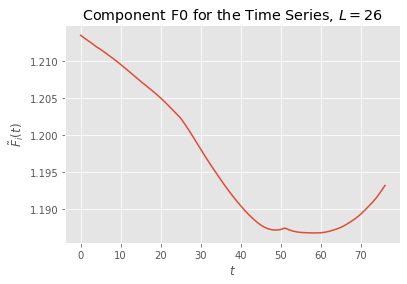

In [54]:
df_compons_after_gr['F0'].plot()

plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component F0 for the Time Series, $L=26$");

<Figure size 1440x720 with 0 Axes>

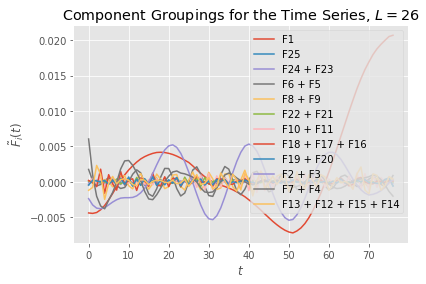

In [55]:
plt.figure(figsize=(20, 10))
df_compons_after_gr.iloc[:, 1:].plot()

plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for the Time Series, $L=26$");

In [56]:
df_compons_after_gr.columns

Index(['F0', 'F1', 'F25', 'F24 + F23', 'F6 + F5', 'F8 + F9', 'F22 + F21',
       'F10 + F11', 'F18 + F17 + F16', 'F19 + F20', 'F2 + F3', 'F7 + F4',
       'F13 + F12 + F15 + F14'],
      dtype='object')

### Посмотрим как это соотносится с графиком собственных значений

In [57]:
X = np.array([pd.Series(F).values[i:L+i] for i in range(0, N-L+1)]).T
U, Sigma, VT = np.linalg.svd(X)
d = np.linalg.matrix_rank(X)

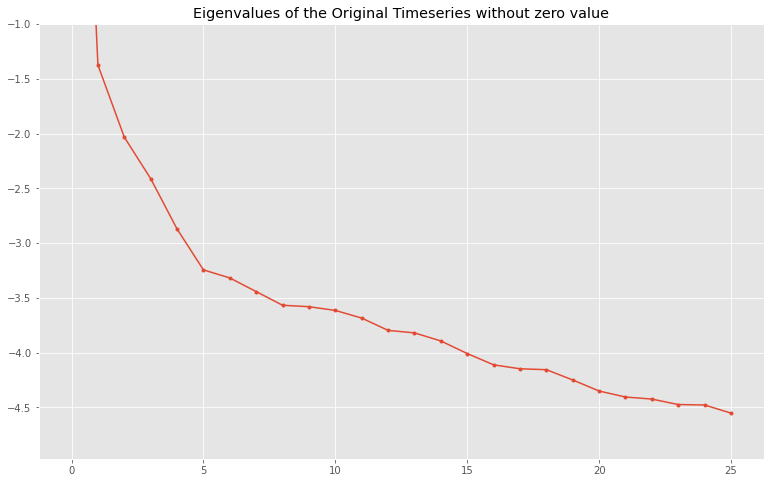

In [58]:
# посмотрим как это соотносится с графиком собственных значений
plt.figure(figsize=(13, 8))
plt.plot(np.log(Sigma), marker=".")
plt.ylim(top=-1)
plt.title('Eigenvalues of the Original Timeseries without zero value');

### Тестирование компонент на нормальность

In [59]:
trend_vals = []
noise_vals = []

trend_comps = []
noise_comps = []

# H0: выборка происходит из нормального распределения.

for i in range(df_compons_after_gr.shape[1]):
    component = df_compons_after_gr.iloc[:, i]
    print(df_compons_after_gr.columns[i], ':', end=' ')
    test = sm.stats.lilliefors(component.to_numpy())

    if test[1] >= 0.05:
        print(test, ', H0 НЕ отвергается', sep='')
        noise_vals.append(component)
        noise_comps.append(df_compons_after_gr.columns[i])
    else:
        print(test, ', H0 отвергается', sep='')
        trend_vals.append(component)
        trend_comps.append(df_compons_after_gr.columns[i])

F0 : (0.17375650697174405, 0.0009999999999998899), H0 отвергается
F1 : (0.19026461379100512, 0.0009999999999998899), H0 отвергается
F25 : (0.10772275006824818, 0.04231201708558177), H0 отвергается
F24 + F23 : (0.06816331401820663, 0.5699663059605032), H0 НЕ отвергается
F6 + F5 : (0.07526707277096695, 0.41661083910765173), H0 НЕ отвергается
F8 + F9 : (0.061546417655564956, 0.7285373486698843), H0 НЕ отвергается
F22 + F21 : (0.11920218262783933, 0.015545019194874799), H0 отвергается
F10 + F11 : (0.06178609884329611, 0.7227934932770549), H0 НЕ отвергается
F18 + F17 + F16 : (0.08231465614084266, 0.27615528768522735), H0 НЕ отвергается
F19 + F20 : (0.06622962184491388, 0.6163063976580534), H0 НЕ отвергается
F2 + F3 : (0.11151628906987926, 0.03025879142190756), H0 отвергается
F7 + F4 : (0.09214317403360062, 0.15243251034993485), H0 НЕ отвергается
F13 + F12 + F15 + F14 : (0.05386618453626968, 0.8815469449937398), H0 НЕ отвергается


In [60]:
print(len(trend_vals), len(noise_vals))

5 8


In [61]:
trend_comps

['F0', 'F1', 'F25', 'F22 + F21', 'F2 + F3']

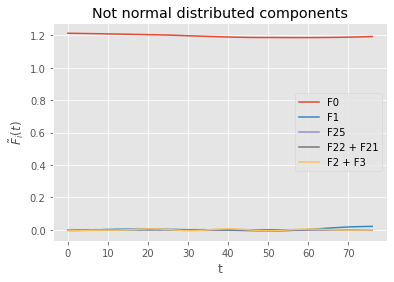

In [62]:
df_compons_after_gr[trend_comps].plot()
plt.xlabel("t")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title('Not normal distributed components');

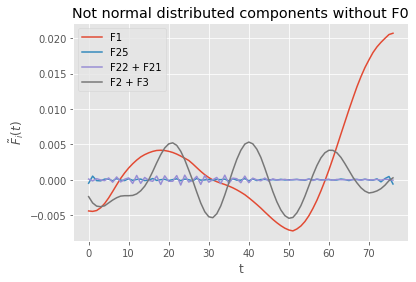

In [63]:
df_compons_after_gr[trend_comps[1:]].plot()
plt.xlabel("t")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title('Not normal distributed components without F0');

In [64]:
noise_comps

['F24 + F23',
 'F6 + F5',
 'F8 + F9',
 'F10 + F11',
 'F18 + F17 + F16',
 'F19 + F20',
 'F7 + F4',
 'F13 + F12 + F15 + F14']

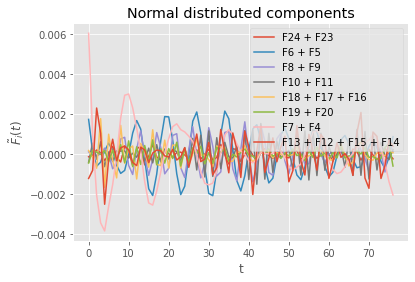

In [65]:
df_compons_after_gr[noise_comps].plot()
plt.xlabel("t")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title('Normal distributed components');

In [66]:
trend_comp = df_compons_after_gr[trend_comps].sum(axis=1) #группируем трендовые
 
noise_comp = df_compons_after_gr[noise_comps].sum(axis=1)        

#### Еще раз посмотрим на нормальность теперь уже итоговых компонент

In [67]:
sm.stats.lilliefors(trend_comp.to_numpy())

(0.12749314722821736, 0.006452391341418659)

In [68]:
sm.stats.lilliefors(noise_comp.to_numpy())

(0.08431519347946342, 0.24211597361467202)

Для трендовой гипотеза о нормальности отвергается, для шума не отвергается, как и должно быть

### Визуализация до и после отделения от шума

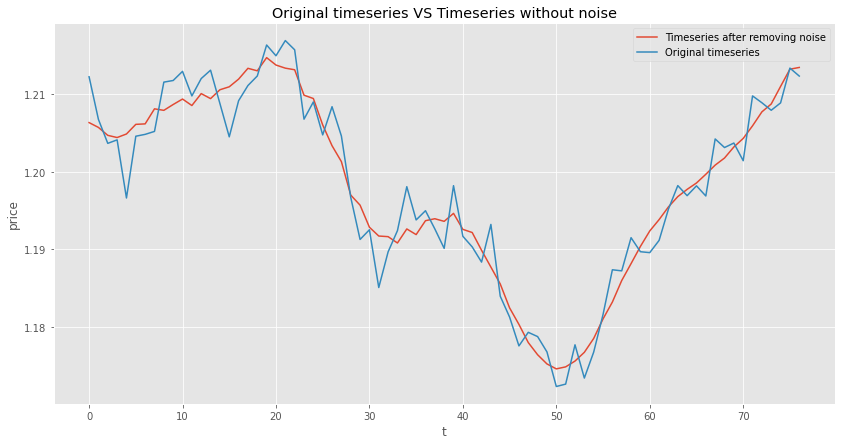

In [69]:
plt.figure(figsize=(14, 7))
trend_comp.plot()
pd.Series(open_price).plot()

plt.xlabel('t')
plt.ylabel('price')
plt.title('Original timeseries VS Timeseries without noise');
plt.legend(['Timeseries after removing noise', 
            'Original timeseries']);

# AutoARIMA

In [70]:
#общее для трех дф
model_autoARIMA = AutoARIMA(start_p=0, d=None, start_q=0,
                       seasonal=False, suppress_warnings=True, stepwise=False, n_jobs=-1)

In [71]:
def quality_metrics(y_real, y_pred):
    
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))
    mae = mean_absolute_error(y_real, y_pred)
    mape = 100. / len(y_real) * np.abs(1. - y_pred/y_real).sum()
    
    return [rmse, mae, mape]


metrics = pd.DataFrame(columns=['RMSE', 'MAE', 'MAPE'])

## AutoARIMA на исходных данных

In [72]:
orig_timeseries = pd.Series(open_price)

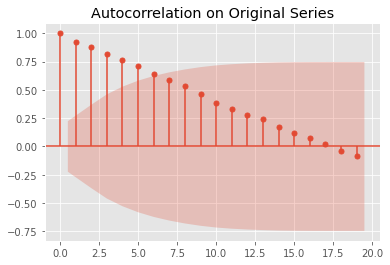

In [73]:
fig = plot_acf(orig_timeseries, title="Autocorrelation on Original Series") 

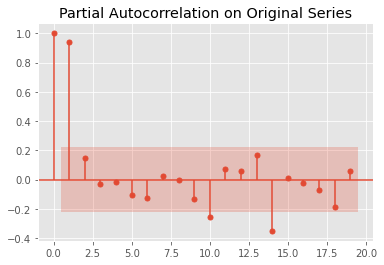

In [74]:
fig = plot_pacf(orig_timeseries, title="Partial Autocorrelation on Original Series") 

In [75]:
train = orig_timeseries[:int(len(orig_timeseries)*0.9)]
#train.to_excel("train_orig.xlsx")  
test = orig_timeseries[len(train):]

In [76]:
fit = model_autoARIMA.fit(train)
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   69
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 276.496
Date:                Sun, 20 Jun 2021   AIC                           -548.993
Time:                        05:16:46   BIC                           -544.554
Sample:                             0   HQIC                          -547.234
                                 - 69                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0001      0.001     -0.265      0.791      -0.001       0.001
sigma2      1.721e-05   3.51e-06      4.905      0.000    1.03e-05    2.41e-05
===================================================================================
Ljung-Box (L1) (Q):                   1.33   Jarque-Bera (JB):                 1.13
Prob(Q):                              0.25   Prob(JB):                         0.57
Heteroskedasticity (H):               0.70   Skew:                            -0.14
Prob(H) (two-sided):                  0.40   Kurtosis:                         2.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [77]:
fh = ForecastingHorizon(test.index, is_relative=False)

In [78]:
# прогноз и доверительные интервалы
y_pred_orig, y_intervals_orig = model_autoARIMA.predict(fh, return_pred_int=True)

In [79]:
metrics.loc['original timeseries', :] = quality_metrics(test.values, y_pred_orig.values)
metrics

RMSE       MAE      MAPE
original timeseries  0.007042  0.006132  0.506624

## AutoARIMA на очищенных визуальной группировкой данных

In [80]:
timeseries_clean_vis = comp1

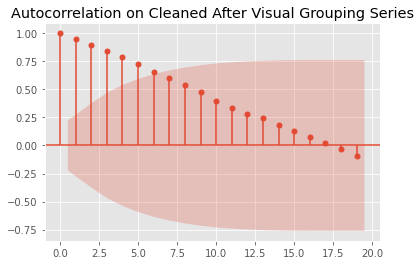

In [81]:
acf_cl_vis = plot_acf(timeseries_clean_vis, title="Autocorrelation on Cleaned After Visual Grouping Series") 

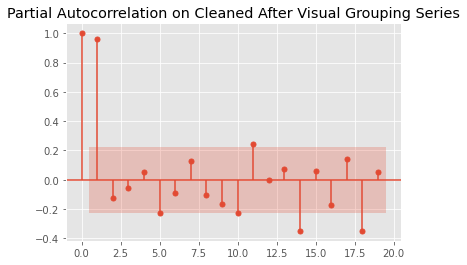

In [82]:
pacf_cl_vis = plot_pacf(timeseries_clean_vis, title="Partial Autocorrelation on Cleaned After Visual Grouping Series") 

In [83]:
train_cl_vis = timeseries_clean_vis[:int(len(timeseries_clean_vis)*0.9)]
#train_cl_vis.to_excel("train_cl_vis.xlsx")  
test_cl_vis = timeseries_clean_vis[len(train_cl_vis):]

In [84]:
fit_cl_vis = model_autoARIMA.fit(train_cl_vis)

In [85]:
fit_cl_vis.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   69
Model:               SARIMAX(1, 1, 2)   Log Likelihood                 324.693
Date:                Sun, 20 Jun 2021   AIC                           -639.386
Time:                        05:16:50   BIC                           -628.288
Sample:                             0   HQIC                          -634.989
                                 - 69                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0005      0.001     -0.586      0.558      -0.002       0.001
ar.L1         -0.7167      0.131     -5.462      0.000      -0.974      -0.460
ma.L1          1.2734      0.157      8.137      0.000       0.967       1.580
ma.L2          0.8103      0.137      5.901      0.000       0.541       1.079
sigma2      4.015e-06    8.4e-07      4.779      0.000    2.37e-06    5.66e-06
===================================================================================
Ljung-Box (L1) (Q):                   2.27   Jarque-Bera (JB):                 5.79
Prob(Q):                              0.13   Prob(JB):                         0.06
Heteroskedasticity (H):               0.52   Skew:                            -0.69
Prob(H) (two-sided):                  0.12   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [86]:
fh_cl_vis = ForecastingHorizon(test_cl_vis.index, is_relative=False)

In [87]:
# прогноз и доверительные интервалы
y_pred_cl_vis, y_intervals_cl_vis = model_autoARIMA.predict(fh_cl_vis, return_pred_int=True)

In [88]:
metrics.loc['timeseries after visual grouping', :] = quality_metrics(test_cl_vis.values, y_pred_cl_vis.values)
metrics

RMSE       MAE      MAPE
original timeseries               0.007042  0.006132  0.506624
timeseries after visual grouping  0.009126   0.00832  0.687646

## AutoARIMA на очищенных группировкой с помощью функции данных

In [91]:
timeseries_cl_func = trend_comp

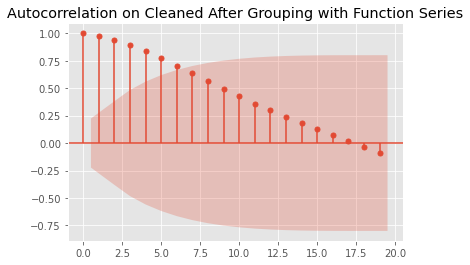

In [92]:
acf_cl_func = plot_acf(timeseries_cl_func, title="Autocorrelation on Cleaned After Grouping with Function Series") 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning:

invalid value encountered in sqrt



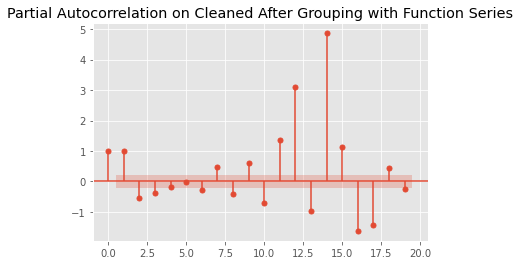

In [93]:
pacf_cl_func = plot_pacf(timeseries_cl_func, title="Partial Autocorrelation on Cleaned After Grouping with Function Series") 

In [94]:
train_cl_func = timeseries_cl_func[:int(len(timeseries_cl_func)*0.9)]
#train_cl_func.to_excel('train_cl_func.xlsx')
test_cl_func = timeseries_cl_func[len(train_cl_func):]

In [95]:
fit_cl_func = model_autoARIMA.fit(train_cl_func)

In [96]:
fit_cl_func.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   69
Model:               SARIMAX(4, 1, 0)   Log Likelihood                 414.029
Date:                Sun, 20 Jun 2021   AIC                           -816.058
Time:                        05:17:23   BIC                           -802.741
Sample:                             0   HQIC                          -810.782
                                 - 69                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.054e-05    7.7e-05     -0.396      0.692      -0.000       0.000
ar.L1          0.2479      0.067      3.717      0.000       0.117       0.379
ar.L2          1.1299      0.076     14.910      0.000       0.981       1.278
ar.L3          0.2524      0.079      3.189      0.001       0.097       0.408
ar.L4         -0.8381      0.069    -12.097      0.000      -0.974      -0.702
sigma2      2.819e-07   4.81e-08      5.862      0.000    1.88e-07    3.76e-07
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.57
Prob(Q):                              0.92   Prob(JB):                         0.46
Heteroskedasticity (H):               0.38   Skew:                            -0.31
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [97]:
fh_cl_func = ForecastingHorizon(test_cl_func.index, is_relative=False)

In [98]:
# прогноз и доверительные интервалы
y_pred_cl_func, y_intervals_cl_func = model_autoARIMA.predict(fh_cl_func, return_pred_int=True)

In [99]:
metrics.loc['timeseries after func grouping', :] = quality_metrics(test_cl_func.values, y_pred_cl_func.values)
metrics

RMSE       MAE      MAPE
original timeseries               0.007042  0.006132  0.506624
timeseries after visual grouping  0.009126   0.00832  0.687646
timeseries after func grouping    0.005628  0.004454  0.367736

наилучшее качество у модели на данных с удалением шума (RMSE, MAE, MAPE - наим)

наихудшее - при визуальной группировке (в принципе, ожидаемо, так как совсем не строгий метод)